# **Grupo 5**
Pedro Paulo Costa Pereira - A88062

Tiago André Oliveira Leite - A91693

In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, IBMQ
from qiskit.tools.visualization import plot_histogram, visualize_transition
from qiskit.tools import job_monitor

from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

import matplotlib.pyplot as plt
import numpy as np

## 1. Formula booleana 3-SAT 

$F = (\neg A \lor \neg B \lor \neg C) \land (A \lor B \lor \neg C)  \land (A \lor \neg B \lor C) \land (A \lor \neg B \lor \neg C) \land (\neg A \lor B \lor C) \land (\neg A \lor B \lor \neg C) \land (\neg A \lor \neg B \lor C)$ 

### Verificar que tem solução

 *Seja:*
 
 $f_1 = A \lor B \lor C$ $\qquad$ $f_2 = A \lor B \lor \neg C$ $\qquad$ $f_3 = A \lor \neg B \lor C$ $\qquad$ 
 $f_4 = A \lor \neg B \lor \neg C$ $\qquad$ $f_5 = \neg A \lor B \lor C$
 
 $f_6 = \neg A \lor B \lor \neg C$ $\qquad$ $f_7 = \neg A \lor \neg B \lor \neg C$
 
 <br>
 
 A | B | C | $f_1$ | $f_2$ | $f_3$ | $f_4$ | $f_5$ | $f_6$ | $f_7$ | $F$
:-:|:-:|:-:|:------|:------|:------|:------|:------|:------|:------|:-- 
 1 | 1 | 1 |   0   |   1   |   1   |   1   |   1   |   1   |   1   |  0
 1 | 1 | 0 |   1   |   1   |   1   |   1   |   1   |   1   |   0   |  0
 1 | 0 | 1 |   1   |   1   |   1   |   1   |   1   |   0   |   1   |  0
 1 | 0 | 0 |   1   |   1   |   1   |   1   |   0   |   1   |   1   |  0
 0 | 1 | 1 |   1   |   1   |   1   |   0   |   1   |   1   |   1   |  0
 0 | 1 | 0 |   1   |   1   |   0   |   1   |   1   |   1   |   1   |  0
 0 | 0 | 1 |   1   |   0   |   1   |   1   |   1   |   1   |   1   |  0
 0 | 0 | 0 |   1   |   1   |   1   |   1   |   1   |   1   |   1   |  1
 
 
<br>

*Solução:* 

$A = 0 \qquad B = 0 \qquad C = 0$


## 2. Algoritmo de resolução

### Função que inicializa o circuito

In [32]:
def init(n,a):
    qr = QuantumRegister(n)
    ancilla = QuantumRegister(a)
    cr = ClassicalRegister(n)
    qc = QuantumCircuit(qr,ancilla,cr)
    
    qc.h(qr)
    qc.x(ancilla)
    qc.h(ancilla)
    qc.barrier() 
    
    return qc, qr, ancilla, cr

### Oráculo

In [33]:
def oracle(qr, ancilla):
    qc = QuantumCircuit(qr,ancilla)
    
    # f1
    qc.mcx(qr,ancilla[0])
    qc.x(ancilla[0])
    
    #f2
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr,ancilla[1])
    qc.x(ancilla[1])
    qc.x(qr[0])
    qc.x(qr[1])
    
    #f3
    qc.x(qr[0])
    qc.x(qr[2])
    qc.mcx(qr,ancilla[2])
    qc.x(ancilla[2])
    qc.x(qr[0])
    qc.x(qr[2])
    
    #f4
    qc.x(qr[0])
    qc.mcx(qr,ancilla[3])
    qc.x(ancilla[3])
    qc.x(qr[0])
    
    
    #f5
    qc.x(qr[1])
    qc.x(qr[2])
    qc.mcx(qr,ancilla[4])
    qc.x(ancilla[4])
    qc.x(qr[1])
    qc.x(qr[2])
    
    #f6
    qc.x(qr[1])
    qc.mcx(qr,ancilla[5])
    qc.x(ancilla[5])
    qc.x(qr[1])
    
    #f7
    qc.x(qr[2])
    qc.mcx(qr,ancilla[6])
    qc.x(ancilla[6])
    qc.x(qr[2])
    
    
    #F
    qc.mcx(ancilla[:-1],ancilla[-1])
    
    qc.barrier()
    return qc

### Difusor

In [34]:
def diffusion_operator(qr, ancilla):

    qc = QuantumCircuit(qr,ancilla)

    #hadamards para passar |psi_0> para |0>
    qc.h(qr)

    #alpha - inverte apenas o |0>
    qc.x(qr)
    qc.h(qr[-1])
    
    qc.mcx(qr[:-1],qr[-1])
    
    qc.h(qr[-1])
    qc.x(qr)
    #hadamards para passar |0> para |psi_0> 
    qc.h(qr)
    
    qc.barrier()
    
    return qc 

## 3. Avaliar a solução 

### Inicialização do circuito

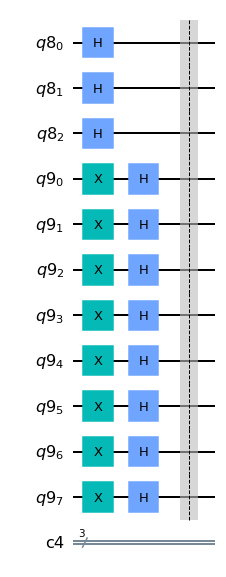

In [35]:
n_qubits = 3
n_ancillas = 8
qc, qr, ancilla, cr = init(n_qubits, n_ancillas)
qc.draw("mpl")

### Cálculo no número de iterações necessárias

In [36]:
elements = 2**n_qubits
iterations= int(np.floor(np.pi/4 * np.sqrt(elements)))
iterations

2

### Composição do circuito com oráculo e difusor

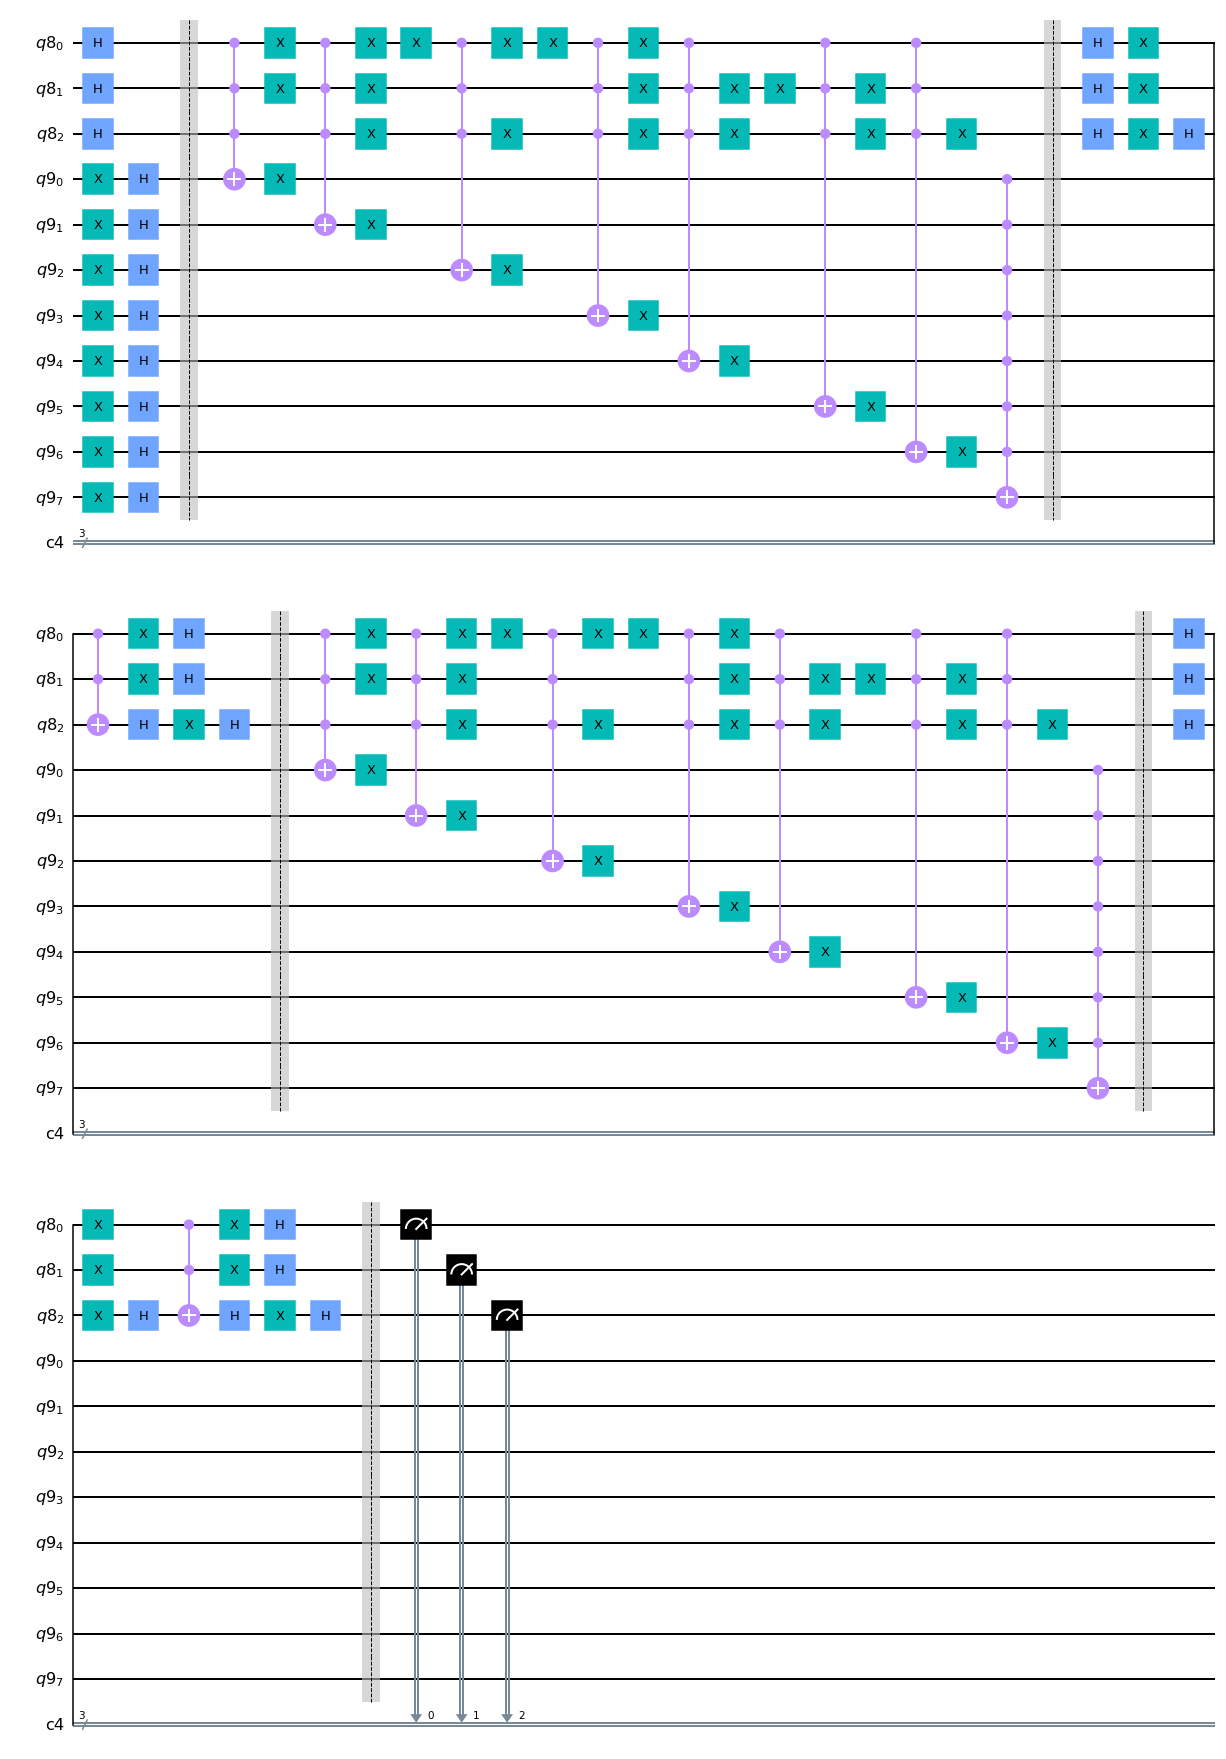

In [37]:
for i in range(iterations):
    qc = qc.compose(oracle(qr,ancilla))
    qc = qc.compose(diffusion_operator(qr,ancilla))

qc.measure(qr,cr)
qc.draw(output="mpl")

### Executar no simulador local

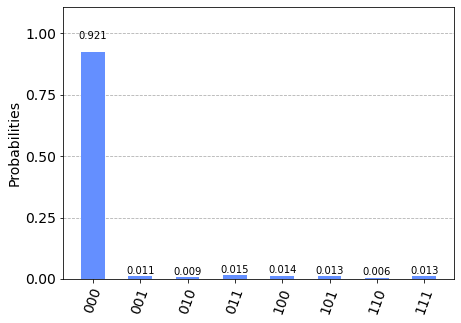

In [38]:
backend = Aer.get_backend('qasm_simulator')
counts = backend.run(qc, shots=1024).result().get_counts()
plot_histogram(counts)

### Executar no IBM Quantum

#### Autenticação no IBM Quantum

In [10]:
#token = 'copiar token da conta IBMQ'  
#IBMQ.active_account()
#IBMQ.save_account(token, overwrite=True)
IBMQ.load_account()

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>]

#### Máquinas disponiveis

In [69]:
#IBMQ.providers()
provider = IBMQ.get_provider()
provider.backends(operational=True)

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo

#### Selecionar máquina

Uma vez que nenhuma das máquinas reais disponiveis tem mais que 7 qubits, teremos que usar um dos simuladores do IBM Quantum.

In [70]:
backend = provider.get_backend('simulator_statevector')
backend.configuration().n_qubits

32

#### Executar circuito

In [71]:
job = execute(qc,backend)

In [72]:
job_monitor(job)

Job Status: job has successfully run


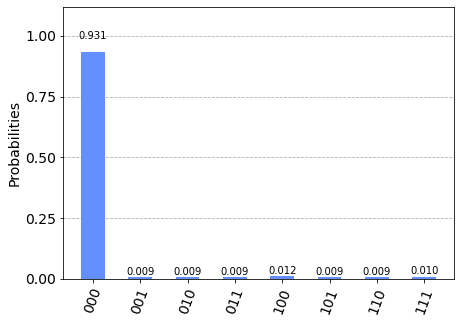

In [73]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

## 4. Análise da complexidade do algoritmo

## Resolução com Qiskit Aqua 

In [75]:
with open('formula.dimacs', 'r') as f:
    dimacs = f.read()
print(dimacs)

c example DIMACS CNF 3-SAT
p cnf 3 5
-1 -2 -3 0
1 2 -3 0
1 -2 3 0
1 -2 -3 0
-1 2 3 0
-1 2 -3 0
-1 -2 3 0


### Simulador Local

#### Obter oráculo

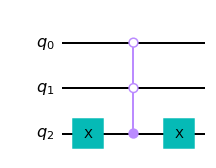

In [76]:
oracle = PhaseOracle.from_dimacs_file('formula.dimacs')
oracle.draw("mpl")

#### Compor e excutar circuito

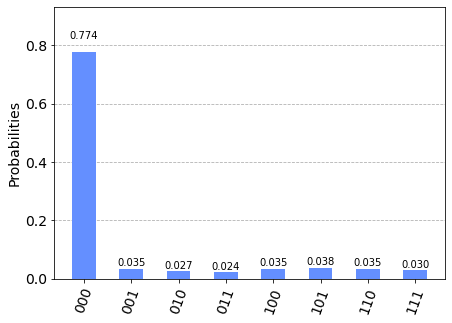

In [77]:
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
problem = AmplificationProblem(oracle=oracle)
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)
plot_histogram(result.circuit_results)

### Máquina Real

#### Construir circuito

In [61]:
qc = grover.construct_circuit(problem, max(result.iterations))
qc.measure_all()

#### Selecionar máquina

In [ ]:
backend = provider.get_backend('simulator_statevector')
backend.configuration().n_qubits

#### Executar circuito

In [66]:
job = execute(qc,backend)

In [ ]:
job_monitor(job)

Job Status: job is queued (8)     

In [ ]:
result = job.result()
counts = result.get_counts()
plot_histogram(counts)